In [1]:
import random
# let's create a linear function with some error called f
def f(x):
    res = x* 25 + 3
    error = res * random.uniform(-0.01, 0.01) # you can play with the error to see how it affects the result
    return res + error

values = []
# now using f we are going to create 300 values.
for i in range(0, 30000):
    x = random.uniform(1, 1000)
    y = f(x)
    values.append((x, y))



In [3]:
from sklearn import linear_model
import xgboost as xgb
import numpy as np
####regr = linear_model.LinearRegression()
regr=xgb.XGBRegressor()
# split the values into two series instead a list of tuples
x, y = zip(*values)
max_x = max(x)
min_x = min(x)
# split the values in train and data.
train_data_X = np.array(map(lambda x: [x], list(x[:-20])))
train_data_X = (train_data_X-train_data_X.mean())
train_data_X /= np.abs(train_data_X).max()
train_data_Y = list(y[:-20])
train_data_Y = np.array(train_data_Y)+np.random.randn(len(train_data_Y))*200-np.random.randn(len(train_data_Y))*400
train_data_Y = (train_data_Y - train_data_Y.mean())
train_data_Y /= np.abs(train_data_Y).max()
test_data_X = map(lambda x: [x], list(x[-20:]))
test_data_Y = list(y[-20:])
# feed the linear regression with the train data to obtain a model.
regr.fit(train_data_X, train_data_Y)
# check that the coeffients are the expected ones.
#m = regr.coef_[0]
#b = regr.intercept_
#print(' y = {0} * x + {1}'.format(m, b))
predictions = regr.predict(train_data_X)

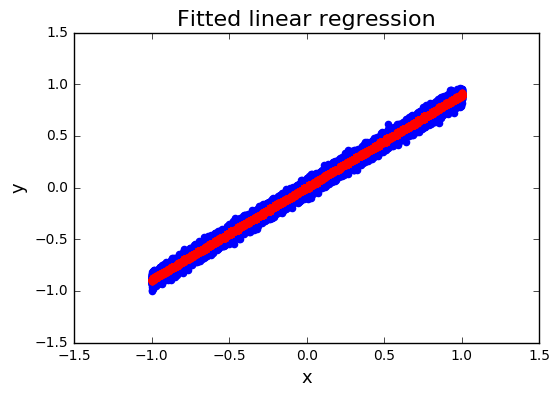

In [4]:
########linear regression

import matplotlib.pyplot as plt

# now we are going to plot the points and the model obtained
plt.scatter(train_data_X, train_data_Y, color='blue')  # you can use test_data_X and test_data_Y instead.
plt.scatter(train_data_X, predictions, color='red')  # you can use test_data_X and test_data_Y instead.

#plt.plot([min_x, max_x], [b, m*max_x + b], 'r')
plt.title('Fitted linear regression', fontsize=16)
plt.xlabel('x', fontsize=13)
plt.ylabel('y', fontsize=13)
plt.show()

In [140]:
######## A class for xgboost implementation of quantile
import numpy as np
from scipy.stats import binom_test

from sklearn.base import BaseEstimator, RegressorMixin
from xgboost.sklearn import XGBRegressor
from functools import partial

class XGBOOSTQUANTILE_2(BaseEstimator, RegressorMixin):
    def __init__(self, quant=0.5,
    n_estimators = 500,max_depth = 5,reg_alpha =0.,reg_lambda=0.,gamma=0.):
        self.quantile = quant
        #xgboost parameters 
        self.n_estimators = n_estimators 
        self.max_depth = max_depth 
        self.reg_alpha= reg_alpha 
        self.reg_lambda = reg_lambda 
        self.gamma = gamma 
        #keep xgboost estimator in memory 
        self.clf = None 
    def fit(self, X, y): 
         def quantile_loss_2(y,preds):

            quantile = self.quantile
                
            """
            Computes first-order derivative of quantile
            regression loss and a non-degenerate
            substitute for second-order derivative.

            Substitute is returned instead of zeros,
            because XGBoost requires non-zero
            second-order derivatives. See this page:
            https://github.com/dmlc/xgboost/issues/1825
            to see why it is possible to use this trick.
            However, be sure that hyperparameter named
            `max_delta_step` is small enough to satisfy:
            ```0.5 * max_delta_step <=
            min(quantile, 1 - quantile)```.
            """
            try:
                assert 0 <= quantile <= 1
            except AssertionError:
                raise ValueError("Quantile value must be float between 0 and 1.")
            mask = y > preds
            grad = -(quantile * mask) + ((1.0 - quantile) * ~mask)            
            hess = np.ones_like(preds)

    
            return grad, hess         

         self.clf = XGBRegressor(
         objective=quantile_loss_2,
#          objective=logregobj,
#                            n_estimators = self.n_estimators,
#                             max_depth = self.max_depth,
#                             reg_alpha =self.reg_alpha, 
#                            reg_lambda = self.reg_lambda,
#                            gamma = self.gamma,
#                            learning_rate=0.1,
#                             min_child_weight=0.002,max_delta_step=0.02*5.
                learning_rate = 0.1,
#                reg_lambda = 0.,
                            base_score=np.percentile(y,50),
                            nthread=10
            )
         self.clf.fit(X,y) 
         print "Daaaaaaa"
         print type(self.clf)
         return self 
    def predict(self, X): 
        y_pred = self.clf.predict(X) 
        return y_pred 
    def score(self, X, y): 
        y_pred = self.clf.predict(X) 
        score = (self.quant_alpha-1.0)*(y-y_pred)*(y<y_pred)+self.quant_alpha*(y-y_pred)* (y>=y_pred) 
        score = 1./np.sum(score) 
        return score

In [141]:
regr2 = XGBOOSTQUANTILE_2(quant=0.5)
regr2.fit(np.array(train_data_X).reshape(-1,1),train_data_Y )
# check that the coeffients are the expected ones.
#m = regr.coef_[0]
#b = regr.intercept_
#print(' y = {0} * x + {1}'.format(m, b))
predictions = regr2.predict(train_data_X)

Daaaaaaa
<class 'xgboost.sklearn.XGBRegressor'>


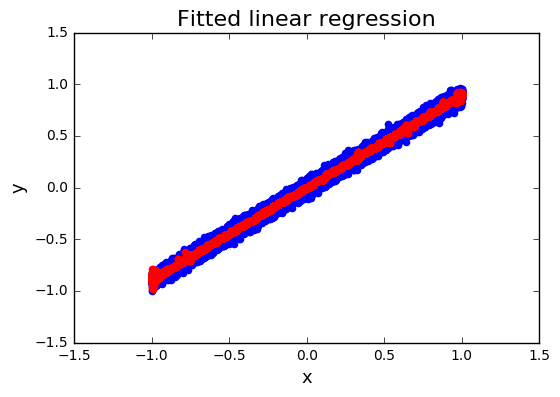

In [142]:
import matplotlib.pyplot as plt

# now we are going to plot the points and the model obtained
plt.scatter(train_data_X,train_data_Y, color='blue')  # you can use test_data_X and test_data_Y instead.
plt.scatter(train_data_X, predictions, color='red')  # you can use test_data_X and test_data_Y instead.

#plt.plot([min_x, max_x], [b, m*max_x + b], 'r')
plt.title('Fitted linear regression', fontsize=16)
plt.xlabel('x', fontsize=13)
plt.ylabel('y', fontsize=13)
plt.show()

In [225]:
######## Semi-parametric regression with xgboost


from sklearn.ensemble import GradientBoostingRegressor
regr3 = GradientBoostingRegressor(loss='quantile',alpha=0.5)
#regr3.fit(np.array(train_data_X).reshape(-1,1), np.array(train_data_Y)+np.random.randn(len(train_data_Y))*200)
regr3.fit(np.array(train_data_X).reshape(-1,1),train_data_Y )

GradientBoostingRegressor(alpha=0.5, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='quantile', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

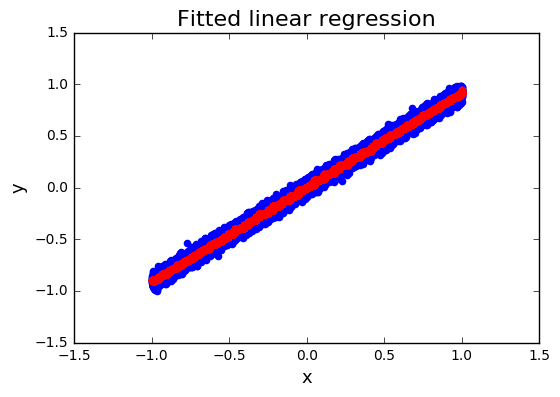

In [228]:
predictions = regr3.predict(train_data_X)
import matplotlib.pyplot as plt

# now we are going to plot the points and the model obtained
plt.scatter(train_data_X, train_data_Y, color='blue')  # you can use test_data_X and test_data_Y instead.
plt.scatter(train_data_X, predictions, color='red')  # you can use test_data_X and test_data_Y instead.

#plt.plot([min_x, max_x], [b, m*max_x + b], 'r')
plt.title('Fitted linear regression', fontsize=16)
plt.xlabel('x', fontsize=13)
plt.ylabel('y', fontsize=13)
plt.show()

In [230]:
######## A class for xgboost implementation of quantile                                                                                                     
import numpy as np
from scipy.stats import binom_test

from sklearn.base import BaseEstimator, RegressorMixin
from xgboost.sklearn import XGBRegressor
from functools import partial
import math

class XGBOOSTQUANTILE(BaseEstimator, RegressorMixin):
    def __init__(self, quant=0.5,
    n_estimators = 500,max_depth = 5,reg_alpha =0.,reg_lambda=0.,gamma=0.):
        self.quantile = quant
        #xgboost parameters                                                                                                                                 
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.reg_alpha= reg_alpha
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        #keep xgboost estimator in memory                                                                                                                   
        self.clf = None
    def fit(self, X, y):
         def quantile_loss(y,preds):

            quantile = self.quantile

            """                                                                                                                                             
            Computes first-order derivative of quantile                                                                                                     
            regression loss and a non-degenerate                                                                                                            
            substitute for second-order derivative.                                                                                                         
                                                                                                                                                            
            Substitute is returned instead of zeros,                                                                                                        
            because XGBoost requires non-zero    
                        second-order derivatives. See this page:                                                                                                        
            https://github.com/dmlc/xgboost/issues/1825                                                                                                     
            to see why it is possible to use this trick.                                                                                                    
            However, be sure that hyperparameter named                                                                                                      
            `max_delta_step` is small enough to satisfy:                                                                                                    
            ```0.5 * max_delta_step <=                                                                                                                      
            min(quantile, 1 - quantile)```.                                                                                                                 
            """
            try:
                assert 0 <= quantile <= 1
            except AssertionError:
                raise ValueError("Quantile value must be float between 0 and 1.")
            mask =  preds > y
#            grad = -(quantile * mask) + ((1.0 - quantile) * ~mask)
            ####func is 2*(sqrt(1+q*x)-1)
            grad = (quantile*mask/np.sqrt(1+quantile*(preds-y))-quantile*~mask/np.sqrt(1-quantile*(preds-y)))
#            hess = np.ones_like(preds) 
            hess = (-0.5*quantile*quantile*mask/(np.power(1+quantile*(preds-y),1.5))-0.5*quantile*quantile*~mask/(np.power(1-quantile*(preds-y),1.5)))
            print preds[0],y[0],grad[0],hess[0]


            return grad, hess

         self.clf = XGBRegressor(
         objective=quantile_loss,
#          objective=logregobj,                                                                                                                             
#                            n_estimators = self.n_estimators,                                                                                              
#                             max_depth = self.max_depth,                                                                                                   
#                             reg_alpha =self.reg_alpha,                                                                                                    
#                            reg_lambda = self.reg_lambda,             
            #                            gamma = self.gamma,                                                                                                            
#                            learning_rate=0.1,                                                                                                             
#                             min_child_weight=0.002,                                                                                                       
#                learning_rate = 0.1,                                                                                                                       
#                reg_lambda = 0.,
#                max_delta_step=self.quantile*10/0.5,
#                           base_score=np.percentile(y,50),                                                                                                
#                            nthread=10,max_delta_step=0.02*5.
            nthread=5)
         self.clf.fit(X,y)
         print "Daaaaaaa"
         print type(self.clf)
         return self
    def predict(self, X):
        y_pred = self.clf.predict(X)
        return y_pred
    def score(self, X, y):
        y_pred = self.clf.predict(X)
        score = (self.quant_alpha-1.0)*(y-y_pred)*(y<y_pred)+self.quant_alpha*(y-y_pred)* (y>=y_pred)
        score = 1./np.sum(score)
        return score



In [231]:
regr4 = XGBOOSTQUANTILE(quant=0.5)
regr4.fit(np.array(train_data_X).reshape(-1,1),train_data_Y )
# check that the coeffients are the expected ones.
#m = regr.coef_[0]
#b = regr.intercept_
#print(' y = {0} * x + {1}'.format(m, b))
predictions = regr4.predict(train_data_X)

0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.0944904311605
0.5 0.0898461 0.455472978858 -0.09

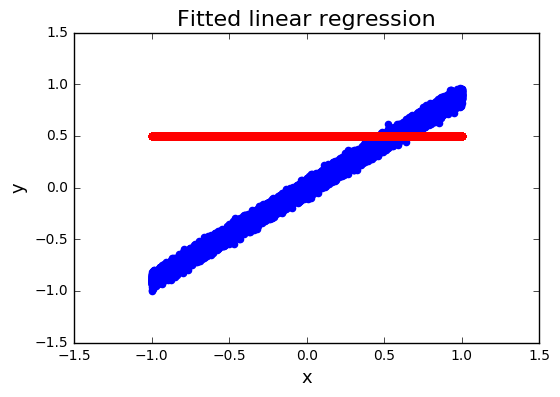

In [232]:
predictions = regr4.predict(train_data_X)
import matplotlib.pyplot as plt

# now we are going to plot the points and the model obtained
plt.scatter(train_data_X, train_data_Y, color='blue')  # you can use test_data_X and test_data_Y instead.
plt.scatter(train_data_X, predictions, color='red')  # you can use test_data_X and test_data_Y instead.

#plt.plot([min_x, max_x], [b, m*max_x + b], 'r')
plt.title('Fitted linear regression', fontsize=16)
plt.xlabel('x', fontsize=13)
plt.ylabel('y', fontsize=13)
plt.show()